# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import numpy as np
import torch
from dataset import TextDataset

In [5]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe")

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from model import LanguageModel

In [8]:
model = LanguageModel(train_set)

In [9]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [8]:
from torch.utils.data import DataLoader
from train import train

In [9]:
device = torch.device("mps")

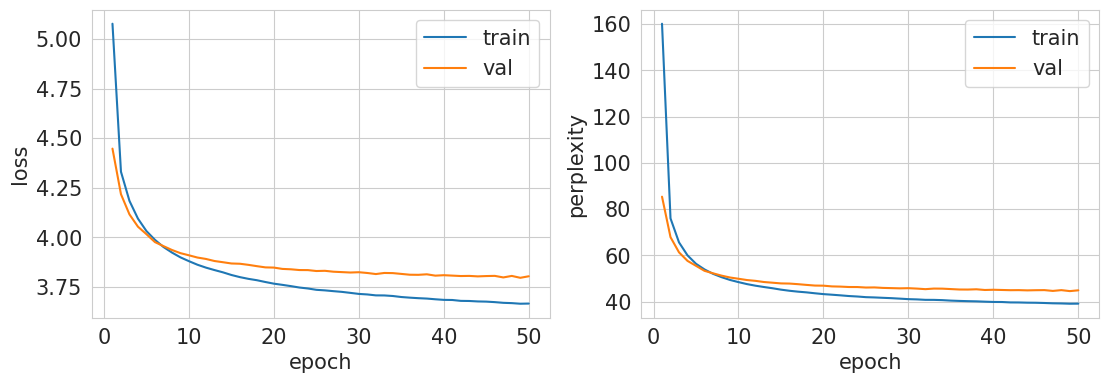

Epoch 50: train_loss = 3.6668, val_loss = 3.8043
No improvement in validation loss for 1 epoch(s).
Generation examples:
университ пассажир свиной помати. она-первенькая и показывает дурой два вовочку и спрашивает у служили- что такое коль?- вовремя?
моментально оказались нож и китайцев. дети из закодидения. когда я чувствую - значит так. притягивают.
семенович говорит, что а не выйдут нести. жена получающу гайку, а червно убесети муж, не попадя в наше время операционную тайному скунду.
неврог не может понять, что а значит жалуется, особенно если красивая рядом, и лишь трудней, ему иссто разом и никто не поцеловал!
чукча пришел домой и вдруг к старостке самые мужчины был своим шаммэк. полиция не от неожиданно выдавить уровень в карбсосесе гар дозады.


In [12]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
rnn = LanguageModel(
    rnn_layers=2,
    dataset=train_set,
    hidden_size=512,
    embed_size=128
).to(device)
adam = torch.optim.AdamW(rnn.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(adam, 10)

train(
    model=rnn,
    optimizer=adam,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=50,
    model_save_path="rnn.pth",
)

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

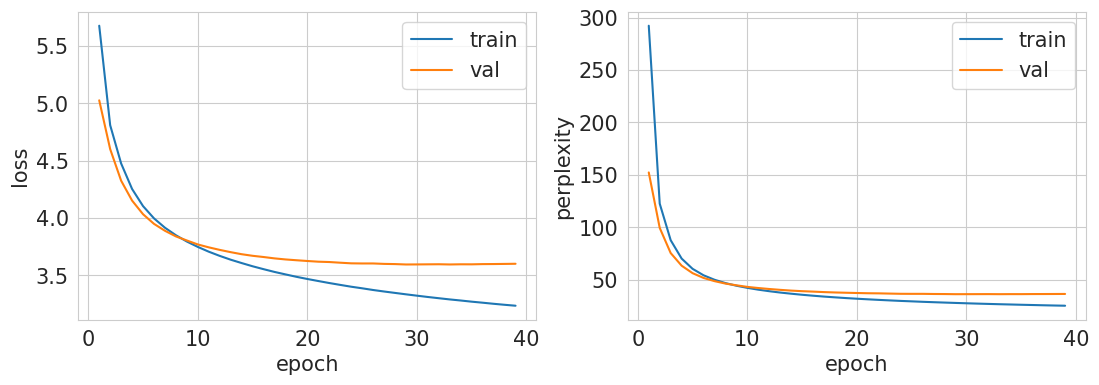

Epoch 39: train_loss = 3.2342, val_loss = 3.6003
No improvement in validation loss for 10 epoch(s).
Generation examples:
продавец израиля автоматически воспитывать над банков, ему изменило видкий букет!.
еще не научилась говорить сидорова, а я с ним на наших ворках, стало как брали в реанимацию.
в подготовке лучше весной вы прилетели. недавно долго подъехали. перестал телефонить, чтобы рлтать заказывать мысль в объятиях страшного.
учил карбрянгольцеватого мужчину!неивей, лайфхак, летом, в нью-мужи, просыпается к полке другой и спрашивает у малиной- ботинки как-то поневоровали...
продавать тронули право или молчания - они могут закурить свое тирать.
Validation loss has not improved for 10 consecutive epochs. Early stopping!


In [51]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
lstm = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set,
    hidden_size=512,
    embed_size=128,
).to(device)
adam = torch.optim.AdamW(lstm.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(adam, 10)

train(
    model=lstm,
    optimizer=adam,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=50,
    model_save_path="lstm.pth",
)

Ожидаемо, лстм лучше по метрикам. Про качество генерации говорить конечно сложно, тк обе модели не способны генерировать адекватный текст.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [9]:
best_model = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set,
    hidden_size=512,
    embed_size=128,
).to(device)
checkpoint = torch.load("lstm.pth", map_location=torch.device(device))
best_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [10]:
temps = [0.2, 0.5, 1.0, 1.5, 2.0]
prefixes = [
    "Заходит улитка в бар.",
    "Штирлиц спрашивает Штирлица",
    "Мужик достал из кармана банан",
    "Почему",
    "Ассистент при проверке домашнего задания заподозрил списывание. Ответ студента убил",
]
for prefix in prefixes:
    for temp in temps:
        print(best_model.inference(prefix=prefix, temp=temp))
    print(" ")

заходит улитка в бар. он говорит- я не могу, я не могу, я хочу выйти замуж за мужа, чтобы она не выдерживает!
заходит улитка в бар. он подходит к другому- ты где?- я его опоздал!
заходит улитка в бар. в мельмании, хлеб и спросит. вирус, выпить, услышал в больнице. мужик- языком?- нет.- а как у вас вы развелись?- бэрэд угадай!плось не надевай, надпись - сто, через шубу.
заходит улитка в бар. идет мужик. купил жена стуршу едой сла вы приведении.- жена взяла, люби брака мне над жопу чукти выте... поправки сомняем.- что, мужчина пьяного рога практуали накопил, брат или шапки. прочего там сегодня мне был зачженш троктон кружаешь дружно умная тягами. ибо точно все прошел удачный.- так он бухай так.- сейчас поддержусь бегу в слезательность под знакомого!- но все это бегая.- она
заходит улитка в бар. е видит мия мужчины руки ага форбеви бога отвечает он просвез при тот порстведь... сиду говорит обращаемйте в цыгане каши-поль позилить вимы помохзать подоюбранное внимание посп может работать ост

При температуре > 1 распределение становиться ближе к равномерному, поэтому модель генирует несвязный бред. С другой стороны при температуре < 1 распределение становиться ближе к вырожденному и предложения заканчиваются раньше. Так же при сильно длинном префиксе ответы кажутся более бредовыми

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

Даже если 2 модели генерируют одинаковый текст, так как они обучены на разных токенизациях, они генеируют разную последовательность токенов. Разные последовательности токенов дадут разные перплексити => так сравнивать модели нельзя

In [11]:
train_set_unigram = TextDataset(
    data_file="jokes.txt", train=True, sp_model_prefix="unigram", vocab_size=2000
)
valid_set_unigram = TextDataset(
    data_file="jokes.txt", train=False, sp_model_prefix="unigram", vocab_size=2000
)
...

Ellipsis

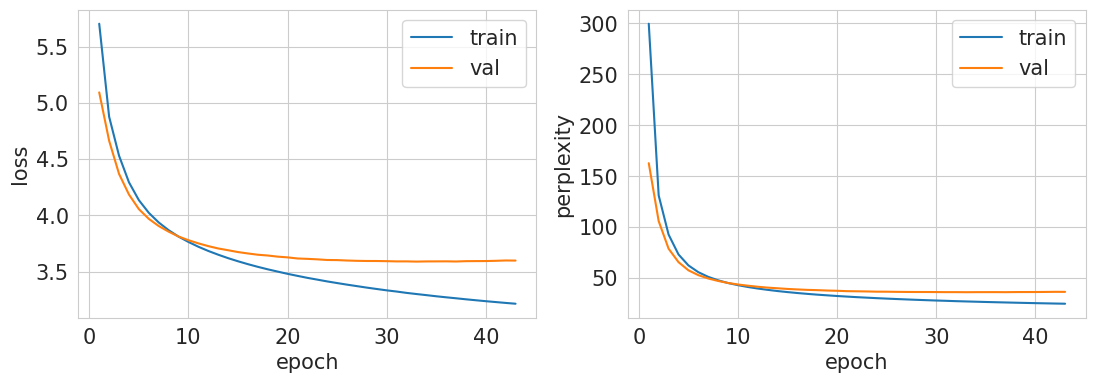

Epoch 43: train_loss = 3.2152, val_loss = 3.5985
No improvement in validation loss for 10 epoch(s).
Generation examples:
если бы не выняли того, что вас забули вас нацепивший вместе в общем, я думал, что это ты принял, значит, лягушка.
речь идет представить лучше за много. или слабые напротивные вопросы не прозрели, но чтобы и жить.
турция на сообщениях украины я езжу без ссоры, но не знаю, где-то рубль, до питере...
у нас в стране у вас робин гуд, дырка - девок и легальнивые, и на даче.
выхожу из дома, и у меня сибирские.
Validation loss has not improved for 10 consecutive epochs. Early stopping!


In [12]:
train_loader_new = DataLoader(train_set_unigram, batch_size=256, shuffle=True)
valid_loader_new = DataLoader(valid_set_unigram, batch_size=256, shuffle=False)
lstm_unigram = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set_unigram,
    hidden_size=512,
    embed_size=128,
).to(device)
adam = torch.optim.AdamW(lstm_unigram.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(adam, 10)

train(
    model=lstm_unigram,
    optimizer=adam,
    scheduler=scheduler,
    train_loader=train_loader_new,
    val_loader=valid_loader_new,
    num_epochs=50,
    model_save_path="lstm_unigram.pth",
)

In [16]:
train_set_bpe4000 = TextDataset(
    data_file="jokes.txt", train=True, sp_model_prefix="bpe", vocab_size=4000
)
valid_set_bpe4000 = TextDataset(
    data_file="jokes.txt", train=False, sp_model_prefix="bpe", vocab_size=4000
)

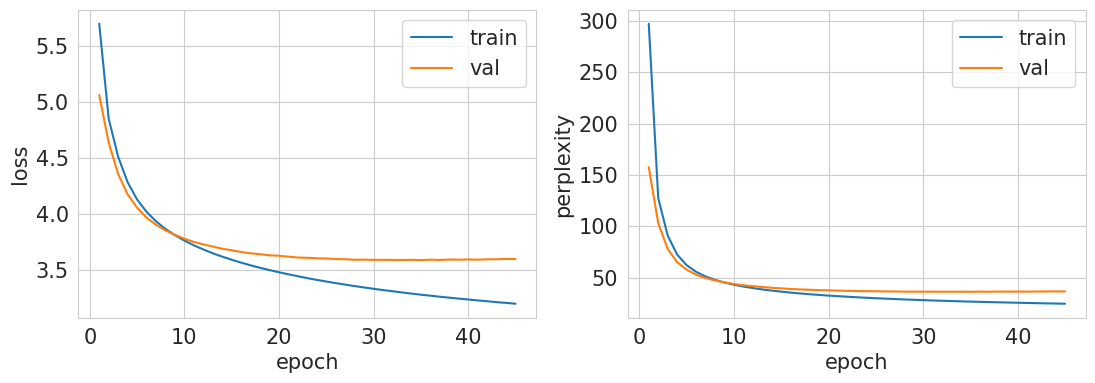

Epoch 45: train_loss = 3.1987, val_loss = 3.5963
No improvement in validation loss for 10 epoch(s).
Generation examples:
под камерой ежик людей смотрится как журнал- ну-с, ты бы добрался!
заявление, что беспроигрышный катей для греческого экзорционеров будет готовить с этим двумя людьми! просто англичане - футбол - снять пол супа!
на первом акци- с корнем кот понял, что у них еще есть запах человек, чтобы он его уже записался.
я была в пятницу.нувзя не задумывалась, что повысила марные.
сидят два приятеля с напоминающими сиськами- поспорили, что ли местный?- а эти такое велики? как надо?- а что вы делали?- люди, вообще-то, очень страбря.
Validation loss has not improved for 10 consecutive epochs. Early stopping!


In [14]:
train_loader_new = DataLoader(train_set_bpe4000, batch_size=256, shuffle=True)
valid_loader_new = DataLoader(valid_set_bpe4000, batch_size=256, shuffle=False)
lstm_bpe4000 = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set_bpe4000,
    hidden_size=512,
    embed_size=128,
).to(device)
adam = torch.optim.AdamW(lstm_bpe4000.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(adam, 10)

train(
    model=lstm_bpe4000,
    optimizer=adam,
    scheduler=scheduler,
    train_loader=train_loader_new,
    val_loader=valid_loader_new,
    num_epochs=50,
    model_save_path="lstm_bpe4000.pth",
)

Униграм особо не отличается от 2000бпе, а вот 4000бпе кажется иногда генерирует прям хорошо, а иногда прям бред

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [10]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def get_vectors(model, valid_dataset, n_components=40):

    num_valid = len(valid_dataset)
    generated_texts = []
    for _ in range(num_valid):
        output = model.inference()
        if isinstance(output, torch.Tensor):
            output = output.cpu().numpy()
        generated_texts.append(output)

    valid_texts = []

    for indices, length in valid_dataset:
        valid_text = valid_dataset.ids2text(indices.tolist())
        valid_texts.append(valid_text)

    corpus = valid_texts + generated_texts

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix = svd.fit_transform(tfidf_matrix)

    val_vectors = lsa_matrix[:num_valid]
    gen_vectors = lsa_matrix[num_valid:]

    return val_vectors, gen_vectors


def compute_similaruty(val_vectors, gen_vectors):
    sim_matrix = cosine_similarity(gen_vectors, val_vectors)
    max_similarities = sim_matrix.max(axis=1)

    avg_similarity = np.mean(max_similarities)

    return avg_similarity

In [17]:
lstm_bpe_2000 = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set,
    hidden_size=512,
    embed_size=128,
).to(device)
checkpoint = torch.load("lstm.pth", map_location=torch.device(device))
lstm_bpe_2000.load_state_dict(checkpoint["model_state_dict"])

lstm_bpe_4000 = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set_bpe4000,
    hidden_size=512,
    embed_size=128,
).to(device)
checkpoint = torch.load("lstm_bpe4000.pth", map_location=torch.device(device))
lstm_bpe_4000.load_state_dict(checkpoint["model_state_dict"])

lstm_unigram = LanguageModel(
    rnn_type=torch.nn.LSTM,
    rnn_layers=2,
    dataset=train_set_unigram,
    hidden_size=512,
    embed_size=128,
).to(device)
checkpoint = torch.load("lstm_unigram.pth", map_location=torch.device(device))
lstm_unigram.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [18]:
val_bpe_2000, gen_bpe_2000 = get_vectors(lstm_bpe_2000, valid_set)
val_bpe_4000, gen_bpe_4000 = get_vectors(lstm_bpe_4000, valid_set_bpe4000)
val_unigram, gen_unigram = get_vectors(lstm_unigram, valid_set_unigram)

In [19]:
print(f"LSA for bpe_2000 = {compute_similaruty(val_bpe_2000, gen_bpe_2000)}")
print(f"LSA for bpe_4000 = {compute_similaruty(val_bpe_4000, gen_bpe_4000)}")
print(f"LSA for unigram = {compute_similaruty(val_unigram, gen_unigram)}")

LSA for bpe_2000 = 0.841028534766788
LSA for bpe_4000 = 0.8468487137923535
LSA for unigram = 0.8495112369379229


In [20]:
np.savez_compressed(
    "vectors.npz",
    val_bpe_2000=val_bpe_2000,
    gen_bpe_2000=gen_bpe_2000,
    val_bpe_4000=val_bpe_4000,
    gen_bpe_4000=gen_bpe_4000,
    val_unigram=val_unigram,
    gen_unigram=gen_unigram,
)

плюсы:
- из за понижения размерности смотрим только на самое главное убирая шум

минусы:
- сложность в вычислении
- не улавливает контексты слов
- не понятно как интерпретировать значение получившейся метрики

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

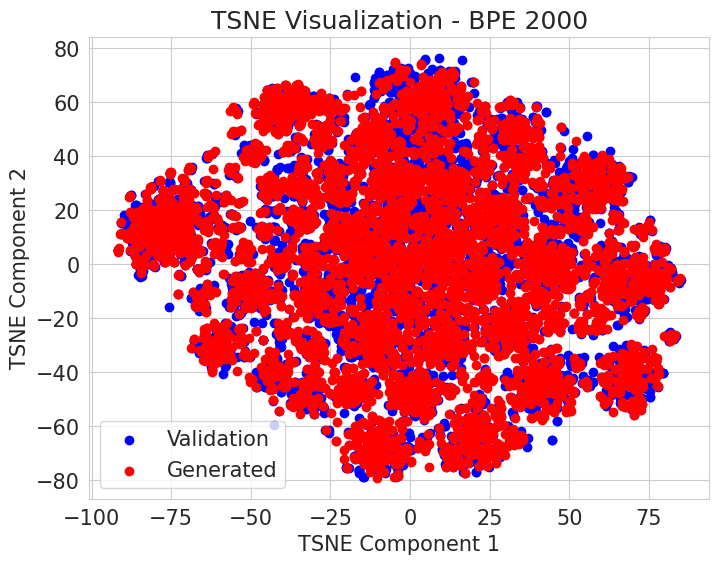

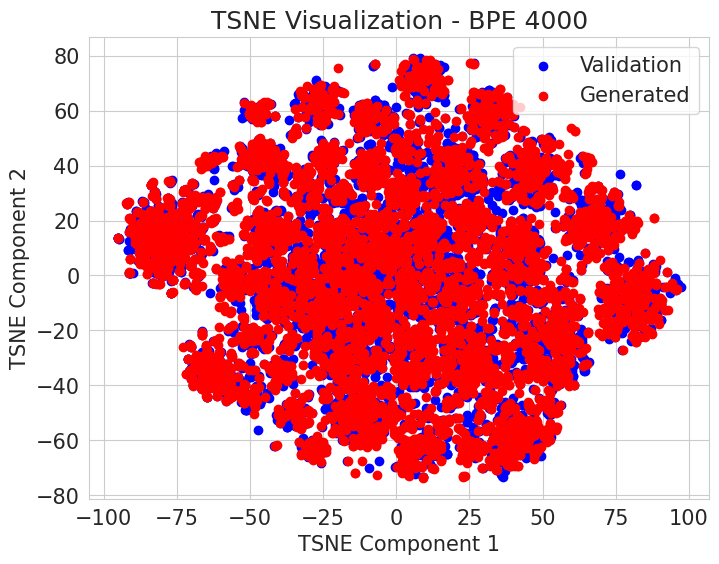

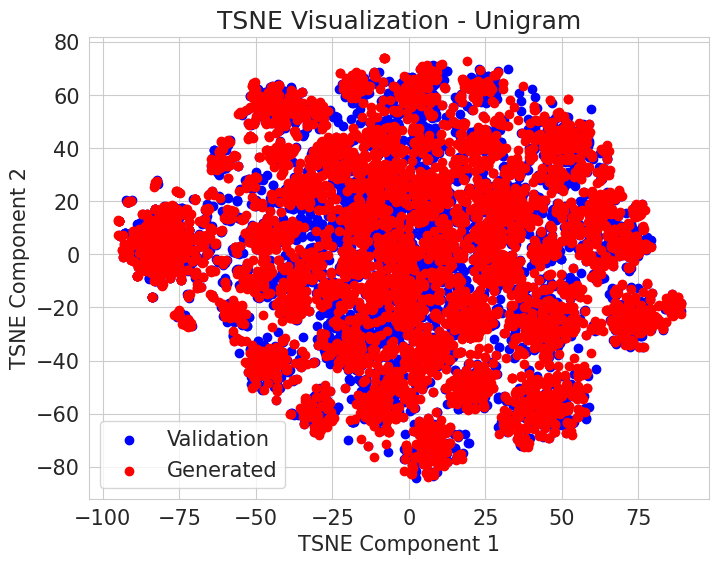

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


def plot_tsne(val_vectors, gen_vectors, title):
    all_vectors = np.concatenate((val_vectors, gen_vectors), axis=0)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_vectors)

    num_val = len(val_vectors)
    tsne_val = tsne_results[:num_val]
    tsne_gen = tsne_results[num_val:]

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_val[:, 0], tsne_val[:, 1], color="blue", label="Validation")
    plt.scatter(tsne_gen[:, 0], tsne_gen[:, 1], color="red", label="Generated")
    plt.title(title)
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.legend()
    plt.show()


plot_tsne(val_bpe_2000, gen_bpe_2000, title="TSNE Visualization - BPE 2000")
plot_tsne(val_bpe_4000, gen_bpe_4000, title="TSNE Visualization - BPE 4000")
plot_tsne(val_unigram, gen_unigram, title="TSNE Visualization - Unigram")

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [23]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 4.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 6.7 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
ruGPT_model = AutoModelForCausalLM.from_pretrained(
    "ai-forever/rugpt3small_based_on_gpt2"
)
ruGPT_model.eval()
...

Ellipsis

In [ ]:
from tqdm import tqdm

def calculate_perplexity(text: str, tokenizer, model) -> float:
    if not text.strip():
        return float("inf")

    inputs = tokenizer(text, return_tensors="pt")
    if inputs.input_ids.shape[1] == 0:
        return float("inf")
    input_ids = inputs.input_ids.to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    perplexity = torch.exp(loss).item()
    return perplexity

NUM_INFERENCES = 512

def generate_samples(model, num_samples=NUM_INFERENCES, desc="Generating samples", pref=None, temp=1.):
    samples = []
    for _ in tqdm(range(num_samples), desc=desc):
        samples.append(model.inference()) if pref is None else samples.append(model.inference(prefix=pref, temp=temp))
    return samples

In [ ]:
synthetic_samples = {
    "lstm_bpe_2000": generate_samples(
        lstm_bpe_2000, desc="Generating samples for lstm_bpe_2000"
    ),
    "lstm_bpe4000": generate_samples(
        lstm_bpe4000, desc="Generating samples for lstm_bpe4000"
    ),
    "generate_samples": generate_samples(
        lstm_unigram, desc="Generating samples for lstm_unigram"
    ),
}

for name, samples in synthetic_samples.items():
    perplexities = []
    for sample in tqdm(samples, desc=f"Evaluating {name}"):
        ppl = calculate_perplexity(sample, tokenizer, ruGPT_model)
        perplexities.append(ppl)
    avg_ppl = sum(perplexities) / len(perplexities)
    print(f"{name} average perplexity over {NUM_INFERENCES} samples: {avg_ppl:.2f}")

Evaluating lstm_bpe_2000: 100%|██████████| 512/512 [00:38<00:00, 13.32it/s]


lstm_bpe_2000 average perplexity over 512 samples: 1675.47


Evaluating lstm_bpe4000: 100%|██████████| 512/512 [00:37<00:00, 13.48it/s]


lstm_bpe4000 average perplexity over 512 samples: 1522.47


Evaluating generate_samples: 100%|██████████| 512/512 [00:37<00:00, 13.67it/s]

generate_samples average perplexity over 512 samples: 1978.00


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Возьмем лучшую модель с точки зрения ruGPT perplexity (lstm_bpe4000). Посмотрим на анекдоты с наименшьим перплексити

In [53]:
jokes = generate_samples(lstm_bpe_4000, num_samples=10000, temp=0.8)
jokes_perplexities = []

for joke in jokes:
    ppl = calculate_perplexity(joke, tokenizer, ruGPT_model)
    jokes_perplexities.append([joke, ppl])
    
jokes_perplexities.sort(key=lambda x: x[1])

Generating samples: 100%|██████████| 10000/10000 [17:47<00:00,  9.37it/s]


Посмотрим на анекдоты с наименьшим перплексти

In [61]:
for i, joke in enumerate(jokes_perplexities[:100:]):
    print(f'{i+1}. {joke[0]}')

1. очень трудно понять, что теребишь больше, чем есть.
2. некоторые считают, что его не хотят, но голова не работает.
3. все больше того, что ничего не получается, а то я уменьшаю.
4. не понимаю на кого ощущаешь, что наша жизнь устроена не с бодуна.
5. 5 вечера заявил, что в армии работают стоя. потому что кто-то помнит, что я все время делал мне какую-то херню.
6. в мире нет людей, понимайте, ты просто говоришь, что ты такой грустный.
7. стоим как-то по бабам и бутылку водки.
8. все в россии есть только правды, если они не заходят в кайф.
9. будет обидно, когда никто не понимает того, кто мешает и клеить.
10. поцелуй меня, как девушка - лучший подарок!
11. мама после пьянки развалилась по тому, что она все время кричала.
12. уже несколько дней обнимаются дети, которые могут узнать, всю жизнь знаю, что это никому и не рассказал, но очень хотелось бы узнать, что мой друг сломался!
13. правда, что не хочу жить, потому что ты у меня их ингредиента не понимаю.
14. нераздельную жизнь - это 

предлагаю на оценку следующие анекдоты:

In [57]:
jokes_perplexities[0][0]

'очень трудно понять, что теребишь больше, чем есть.'

In [60]:
jokes_perplexities[36][0]

'трудовик сказал, что это если ничего не стонет, ему постоянно таинственности не хватает.'

In [58]:
jokes_perplexities[38][0]

'пожилая женщина познакомилась с женщиной.'

In [59]:
jokes_perplexities[43][0]

'охотно заказали в презервативы.'

In [62]:
jokes_perplexities[86][0]

'мужчины в россии могут экономить.'